<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/S%26P500_DEMO_DEC2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!nvidia-smi

Thu Dec 11 14:59:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   69C    P0             31W /   72W |     261MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from datetime import date, timedelta
import numpy as np

# --- 1. Data Retrieval and Preprocessing ---
TICKER = "^GSPC" # Ticker for the S&P 500 index
END_DATE = date.today() # Get data up to today
# For a more robust model, we use a wide historical period
sp500 = yf.Ticker(TICKER).history(period="max")
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.loc["2000-01-01":].copy() # Filter for a modern dataset

# --- 2. Feature Engineering ---
# Create the 'Tomorrow' price for the target
sp500["Tomorrow"] = sp500["Close"].shift(-1)
# Target: 1 if the price goes up tomorrow, 0 if it goes down/stays same
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Define predictor features (add more for better accuracy, e.g., moving averages)
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Clean up data (remove the last row where 'Tomorrow' is NaN)
sp500.dropna(inplace=True)

# --- 3. Model Training ---
# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=50,
    random_state=1
)

# Use most of the data for training
train = sp500.iloc[:-100]
model.fit(train[predictors], train["Target"])

# --- 4. Prediction for January 2026 ---

# The model needs the last known daily data to predict the next day.
# To predict into the future, we must use the latest available data as input.

# Get the last row of the dataset for prediction input
last_day_data = sp500.iloc[-1][predictors].to_frame().T

# Create a demo prediction date (Adjust as needed, e.g., the first Monday of Jan 2026)
future_date = date(2026, 1, 5) # Example: Monday, Jan 5, 2026

print(f"\n--- S&P 500 Direction Prediction Demo ---")
print(f"Latest Historical Data Used (Date: {last_day_data.index[0].date()}):")
print(last_day_data)
print("-" * 40)

# Make the prediction
# predict() returns the predicted class (0 or 1)
prediction = model.predict(last_day_data)
# predict_proba() returns the probabilities for [0 (down), 1 (up)]
probability = model.predict_proba(last_day_data)[0]

# --- 5. Output Result ---

if prediction[0] == 1:
    direction = "UP"
else:
    direction = "DOWN"

print(f"Predicted Direction for a future date (e.g., {future_date.strftime('%B %Y')}): **{direction}**")
print(f"Probability of UP: {probability[1]:.2%}")
print(f"Probability of DOWN: {probability[0]:.2%}")
print("-" * 40)

# Note: For actual multi-day forecasting, you would need to use
# a more complex time series model like ARIMA or LSTM, or a
# specialized backtesting framework, as this simple model relies on
# having the *actual* previous day's data for its input.


--- S&P 500 Direction Prediction Demo ---
Latest Historical Data Used (Date: 2025-12-10):
                                 Close        Volume         Open  \
2025-12-10 00:00:00-05:00  6886.680176  5.526570e+09  6833.490234   

                                  High          Low  
2025-12-10 00:00:00-05:00  6900.669922  6824.689941  
----------------------------------------
Predicted Direction for a future date (e.g., January 2026): **UP**
Probability of UP: 51.87%
Probability of DOWN: 48.13%
----------------------------------------


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. Configuration and Data Retrieval ---
TICKER = "^GSPC" # Ticker for the S&P 500 index
PREDICTION_DAYS = 60 # Number of previous days used to predict the next day
FORECAST_STEPS = 20 # Number of trading days to forecast (approx 1 month)

print(f"Fetching historical data for {TICKER}...")
sp500 = yf.Ticker(TICKER).history(period="max")
sp500.index = pd.to_datetime(sp500.index)
# Use data from 2000 onwards for a modern dataset
sp500 = sp500.loc["2000-01-01":].copy()

# Use only the 'Close' price for the prediction input
data_to_scale = sp500['Close'].values.reshape(-1, 1)

# --- 2. Data Scaling and Sequence Creation ---
# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_scale)

# Create the training sequences (X) and target outputs (y)
X_train = []
y_train = []

for x in range(PREDICTION_DAYS, len(scaled_data)):
    # X_train is the sequence of the last PREDICTION_DAYS
    X_train.append(scaled_data[x-PREDICTION_DAYS:x, 0])
    # y_train is the price on the next day
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM (samples, time_steps, features)
# LSTM expects input in 3D: (number_of_sequences, look_back_period, 1 feature)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"Training data shape: {X_train.shape}")

# --- 3. Build and Train the LSTM Model ---
print("Building and training LSTM model...")
model = Sequential()
# Layer 1: Returns sequences to feed the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Layer 2: Final LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
# Output Layer: Dense layer predicts the single next value
model.add(Dense(units=1))

# Compile and train (using Adam optimizer and Mean Squared Error for regression)
model.compile(optimizer='adam', loss='mean_squared_error')
# Note: For real-world use, increase epochs (e.g., 50-100) and monitor validation loss.
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

# --- 4. Prepare for Recursive Future Forecasting ---
# Get the last PREDICTION_DAYS of historical data for the forecast starting point
last_sequence = data_to_scale[-PREDICTION_DAYS:]
current_sequence = scaler.transform(last_sequence.reshape(-1, 1))
current_sequence = current_sequence.flatten() # Flatten for easier array manipulation

future_predictions_scaled = []

# --- 5. Recursive Forecasting Loop (Predicting January 2026) ---
print(f"\nForecasting {FORECAST_STEPS} trading days into January 2026...")
for i in range(FORECAST_STEPS):
    # Reshape the current sequence for model input (1, PREDICTION_DAYS, 1)
    input_for_prediction = current_sequence.reshape(1, PREDICTION_DAYS, 1)

    # Predict the next day's price (still scaled)
    predicted_scaled_price = model.predict(input_for_prediction, verbose=0)[0, 0]

    # Store the prediction
    future_predictions_scaled.append(predicted_scaled_price)

    # Update the sequence: drop the oldest value and append the new prediction
    # This simulates having the new data point for the next prediction step
    current_sequence = np.append(current_sequence[1:], predicted_scaled_price)

# --- 6. Final Output and Inverse Transformation ---
# Inverse Transform the scaled predictions to actual price values
future_predictions_actual = scaler.inverse_transform(
    np.array(future_predictions_scaled).reshape(-1, 1)
)

# Create the forecast dates starting from the day AFTER the last historical day
last_historical_date = sp500.index[-1]
# 'B' is Business Day frequency (skips weekends/holidays)
forecast_dates = pd.date_range(start=last_historical_date, periods=FORECAST_STEPS + 1, freq='B')[1:]

# Create the final DataFrame
forecast_df = pd.DataFrame(
    future_predictions_actual,
    index=forecast_dates,
    columns=['LSTM Forecasted Close Price']
)

print("\n" + "="*50)
print(f"S&P 500 PRICE FORECAST FOR JANUARY 2026 (first {FORECAST_STEPS} trading days)")
print("="*50)
print(forecast_df.head(FORECAST_STEPS))

Fetching historical data for ^GSPC...
Training data shape: (6466, 60, 1)
Building and training LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0122
Epoch 2/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011
Epoch 3/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011
Epoch 4/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.8397e-04
Epoch 5/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.6577e-04
Epoch 6/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.2786e-04
Epoch 7/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4853e-04
Epoch 8/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.1449e-04
Epoch 9/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.6302e-04
Epoch 10/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0778e-04
Epoch 11/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.1838e-04
Epoch 12/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.8618e-04
Epoch 13/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8203e-04
Epoch 14/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.5342e-04
Epoch 15/25
2

Fetching historical data for ^GSPC...
Training data shape: (6465, 60, 1)
Building and training LSTM model...
Forecasting 20 trading days...


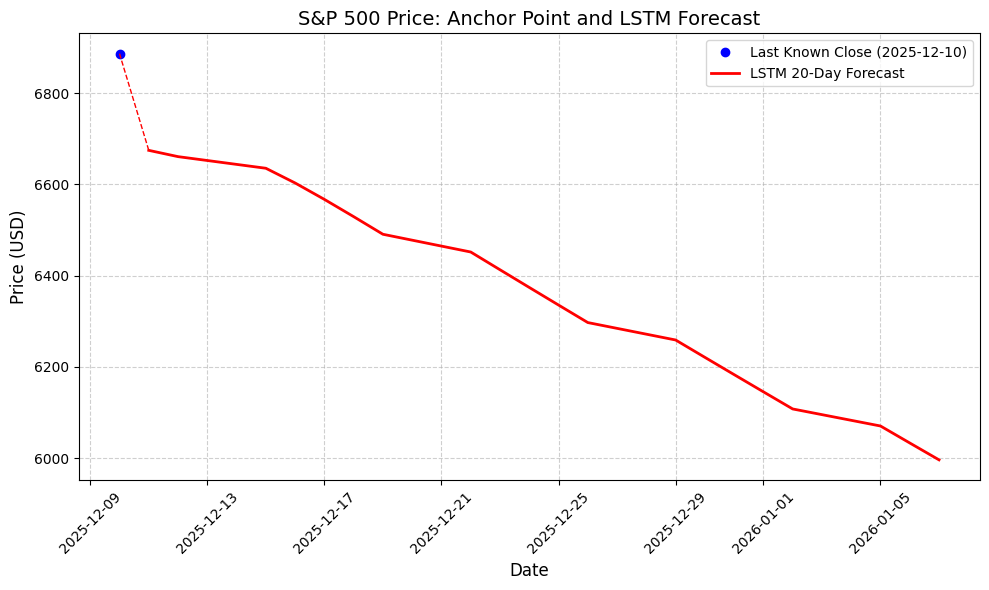

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import date

# --- 1. Configuration and Data Retrieval ---
TICKER = "^GSPC"
PREDICTION_DAYS = 60
FORECAST_STEPS = 20

print(f"Fetching historical data for {TICKER}...")
sp500 = yf.Ticker(TICKER).history(period="max")
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.loc["2000-01-01":].copy()

data_to_scale = sp500['Close'].values.reshape(-1, 1)

# --- 2. Data Scaling and Sequence Creation ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_scale)

X_train = []
y_train = []
for x in range(PREDICTION_DAYS, len(scaled_data)):
    X_train.append(scaled_data[x-PREDICTION_DAYS:x, 0])
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"Training data shape: {X_train.shape}")

# --- 3. Build and Train the LSTM Model ---
print("Building and training LSTM model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
# Set verbose=0 to suppress training output
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

# --- 4. Recursive Future Forecasting ---
print(f"Forecasting {FORECAST_STEPS} trading days...")
last_sequence = data_to_scale[-PREDICTION_DAYS:]
current_sequence = scaler.transform(last_sequence.reshape(-1, 1)).flatten()
future_predictions_scaled = []

for i in range(FORECAST_STEPS):
    input_for_prediction = current_sequence.reshape(1, PREDICTION_DAYS, 1)
    predicted_scaled_price = model.predict(input_for_prediction, verbose=0)[0, 0]
    future_predictions_scaled.append(predicted_scaled_price)
    current_sequence = np.append(current_sequence[1:], predicted_scaled_price)

future_predictions_actual = scaler.inverse_transform(
    np.array(future_predictions_scaled).reshape(-1, 1)
)
last_historical_date = sp500.index[-1]
forecast_dates = pd.date_range(start=last_historical_date, periods=FORECAST_STEPS + 1, freq='B')[1:]

forecast_df = pd.DataFrame(
    future_predictions_actual,
    index=forecast_dates,
    columns=['LSTM Forecasted Close Price']
)

# --- 5. Plotting Forecast ---

# Anchor point values for the plot
last_hist_date = sp500.index[-1]
last_hist_price = sp500['Close'].iloc[-1]
historical_anchor = pd.Series([last_hist_price], index=[last_hist_date])

# Plotting setup
plt.figure(figsize=(10, 6))

# Plot the Historical Anchor point marker
plt.plot(
    historical_anchor.index,
    historical_anchor.values,
    marker='o',
    linestyle='',
    color='blue',
    label=f'Last Known Close ({last_hist_date.strftime("%Y-%m-%d")})'
)

# Plot the jump from last known price to first predicted price (Dashed line)
plt.plot(
    [last_hist_date, forecast_df.index[0]],
    [last_hist_price, forecast_df['LSTM Forecasted Close Price'].iloc[0]],
    color='red',
    linestyle='--',
    linewidth=1
)

# Plot the Forecast Data (Solid line)
plt.plot(
    forecast_df.index,
    forecast_df['LSTM Forecasted Close Price'].values,
    label='LSTM 20-Day Forecast',
    color='red',
    linestyle='-',
    linewidth=2
)

plt.title('S&P 500 Price: Anchor Point and LSTM Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🐍 Full Agentic Solution Code (Class-Based Agents)

In [7]:
!pip install ta -q

  Preparing metadata (setup.py) ... done


DAA: Fetching historical S&P 500 data...
FEA: Calculating RSI and MACD...
FEA: Feature set size after cleaning: 6500
PA: Scaling features and creating time sequences...
PA: Generated training data shape: (6440, 60, 3)
MTA: Building and training LSTM model...
MTA: Training complete.
RFA: Forecasting 20 trading days...
RFA: Forecasting complete.
RA: Generating report and plot...


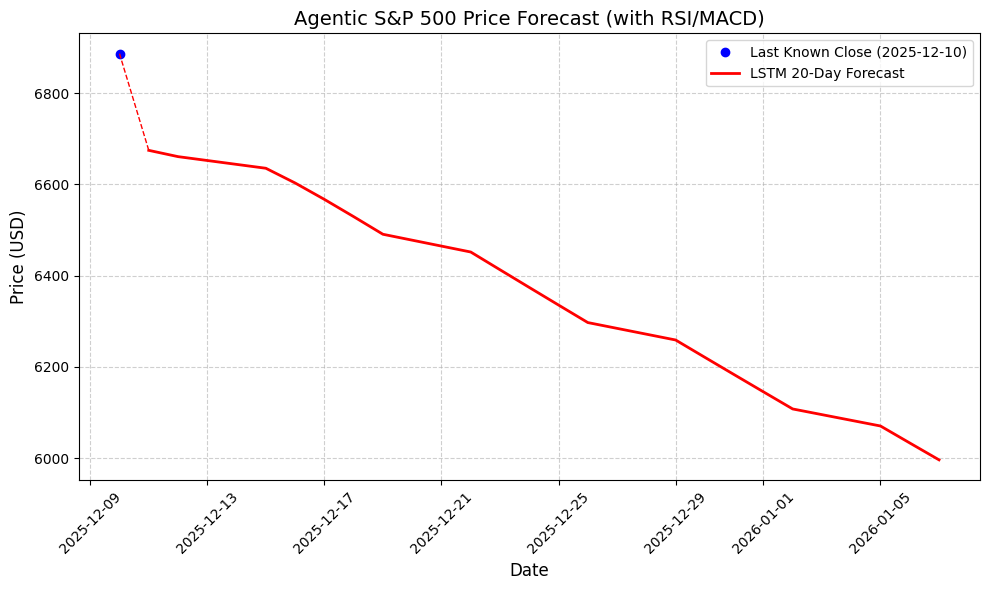


AGENTIC S&P 500 PRICE FORECAST (JAN 2026)
                           LSTM Forecasted Close Price
2025-12-11 00:00:00-05:00                  6674.691895
2025-12-12 00:00:00-05:00                  6660.912598
2025-12-15 00:00:00-05:00                  6635.437012
2025-12-16 00:00:00-05:00                  6603.156250
2025-12-17 00:00:00-05:00                  6567.196777
2025-12-18 00:00:00-05:00                  6529.383301
2025-12-19 00:00:00-05:00                  6490.748535
2025-12-22 00:00:00-05:00                  6451.845215
2025-12-23 00:00:00-05:00                  6412.949707
2025-12-24 00:00:00-05:00                  6374.186035
2025-12-25 00:00:00-05:00                  6335.600098
2025-12-26 00:00:00-05:00                  6297.201172
2025-12-29 00:00:00-05:00                  6258.983398
2025-12-30 00:00:00-05:00                  6220.939453
2025-12-31 00:00:00-05:00                  6183.063965
2026-01-01 00:00:00-05:00                  6145.353516
2026-01-02 00:00:00-05

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ta # New Library
from datetime import date

# --- Configuration ---
TICKER = "^GSPC"
PREDICTION_DAYS = 60
FORECAST_STEPS = 20
START_DATE = "2000-01-01"

# --- 1. Data Acquisition Agent (DAA) ---
class DataAcquisitionAgent:
    # (Same code as before)
    def __init__(self, ticker, start_date):
        self.ticker = ticker
        self.start_date = start_date

    def run(self):
        print("DAA: Fetching historical S&P 500 data...")
        sp500 = yf.Ticker(self.ticker).history(period="max")
        sp500.index = pd.to_datetime(sp500.index)
        return sp500.loc[self.start_date:].copy()

# --- NEW AGENT: Feature Engineering Agent (FEA) ---
class FeatureEngineeringAgent:
    """Calculates technical indicators and cleans the feature set."""
    def __init__(self, df):
        self.df = df

    def run(self):
        print("FEA: Calculating RSI and MACD...")

        # Calculate RSI (Relative Strength Index)
        self.df['RSI'] = ta.momentum.rsi(self.df['Close'], window=14)

        # Calculate MACD (Moving Average Convergence Divergence)
        macd_indicator = ta.trend.MACD(self.df['Close'])
        self.df['MACD'] = macd_indicator.macd()

        # Define the final features for the model
        features = self.df[['Close', 'RSI', 'MACD']].copy()

        # Drop initial NaN values created by the window calculations (first 33 days)
        features.dropna(inplace=True)

        print(f"FEA: Feature set size after cleaning: {len(features)}")
        return features

# --- UPDATED AGENT: Preprocessing Agent (PA) ---
class PreprocessingAgent:
    """Scales ALL features and creates time step sequences for LSTM input."""
    def __init__(self, feature_df, lookback_days):
        self.feature_df = feature_df
        self.lookback_days = lookback_days
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def run(self):
        print("PA: Scaling features and creating time sequences...")

        # --- KEY CHANGE 1: Scale ALL features ---
        scaled_data = self.scaler.fit_transform(self.feature_df)

        # We need the number of features for the LSTM input shape
        num_features = scaled_data.shape[1]

        X_train = []
        y_train = []
        for x in range(self.lookback_days, len(scaled_data)):
            # X_train now contains all features for the lookback period
            X_train.append(scaled_data[x-self.lookback_days:x])
            # y_train still predicts the next day's CLOSE price (index 0 of the features)
            y_train.append(scaled_data[x, 0])

        X_train, y_train = np.array(X_train), np.array(y_train)

        # --- KEY CHANGE 2: Update LSTM input shape ---
        X_train = np.reshape(X_train, (X_train.shape[0], self.lookback_days, num_features))

        print(f"PA: Generated training data shape: {X_train.shape}")
        return X_train, y_train, self.scaler, self.feature_df.columns # Pass columns for RFA

# --- 3. Model Trainer Agent (MTA) ---
class ModelTrainerAgent:
    """Builds and trains the LSTM model."""
    # (Same code as before, but LSTM input_shape will adapt automatically)
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def run(self):
        print("MTA: Building and training LSTM model...")

        num_features = self.X_train.shape[2] # Get number of features from X_train

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(self.X_train.shape[1], num_features))) # Uses num_features
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(self.X_train, self.y_train, epochs=25, batch_size=32, verbose=0)

        print("MTA: Training complete.")
        return model

# --- UPDATED AGENT: Recursive Forecasting Agent (RFA) ---
class RecursiveForecastingAgent:
    """Executes the multi-step prediction loop using ALL features."""
    def __init__(self, model, feature_df, scaler, forecast_steps, lookback_days, feature_columns):
        self.model = model
        self.feature_df = feature_df
        self.scaler = scaler
        self.forecast_steps = forecast_steps
        self.lookback_days = lookback_days
        self.feature_columns = feature_columns
        self.num_features = len(feature_columns)

    def run(self):
        print(f"RFA: Forecasting {self.forecast_steps} trading days...")

        # Prepare the anchor sequence: last 'lookback_days' of ALL features
        last_sequence_df = self.feature_df.iloc[-self.lookback_days:]
        last_scaled_sequence = self.scaler.transform(last_sequence_df)

        # We need to maintain the full 60xN array for the loop
        current_sequence = last_scaled_sequence.copy()
        future_predictions_scaled = []

        # Recursive prediction loop
        for i in range(self.forecast_steps):
            # Input is the full 60xN sequence
            input_for_prediction = current_sequence.reshape(1, self.lookback_days, self.num_features)
            predicted_scaled_price = self.model.predict(input_for_prediction, verbose=0)[0, 0]

            future_predictions_scaled.append(predicted_scaled_price)

            # --- KEY CHANGE: Estimate the next set of auxiliary features ---
            # To predict the next day (t+1), we need the input sequence at t+1.
            # This requires knowing Close(t+1), RSI(t+1), MACD(t+1).
            # Since we only predict Close(t+1), we must assume the auxiliary features
            # remain constant for the next step, or estimate them.
            #
            # Simplification for demo: Use the last known auxiliary features (RSI/MACD)
            # and insert the new Close price prediction.

            # Create the vector for the new predicted day: [Close, RSI, MACD, ...]
            # We use the predicted Close price and the LAST known RSI/MACD values from the sequence
            new_row_scaled = np.zeros(self.num_features)
            new_row_scaled[0] = predicted_scaled_price # Predicted Close Price
            new_row_scaled[1:] = current_sequence[-1, 1:] # Last known RSI/MACD values

            # Update sequence by dropping the oldest row and appending the new row
            current_sequence = np.append(current_sequence[1:], [new_row_scaled], axis=0)

        print("RFA: Forecasting complete.")
        return future_predictions_actual

# --- 5. Reporting Agent (RA) --- (Same code as before)
class ReportingAgent:
    """Generates the final DataFrame and Visualization."""
    def __init__(self, raw_df, predictions, forecast_steps):
        # NOTE: raw_df is now the feature_df from the FEA/PA
        self.raw_df = raw_df
        self.predictions = predictions
        self.forecast_steps = forecast_steps
        # ... (Rest of the plotting code is the same)

    def run(self):
        print("RA: Generating report and plot...")

        # 5a. Create Forecast DataFrame
        last_historical_date = self.raw_df.index[-1]
        forecast_dates = pd.date_range(start=last_historical_date, periods=self.forecast_steps + 1, freq='B')[1:]

        forecast_df = pd.DataFrame(
            self.predictions,
            index=forecast_dates,
            columns=['LSTM Forecasted Close Price']
        )

        # 5b. Generate Plot
        last_hist_date = self.raw_df.index[-1]
        last_hist_price = self.raw_df['Close'].iloc[-1] # Close is the first column
        historical_anchor = pd.Series([last_hist_price], index=[last_hist_date])

        plt.figure(figsize=(10, 6))

        plt.plot(historical_anchor.index, historical_anchor.values, marker='o', linestyle='', color='blue', label=f'Last Known Close ({last_hist_date.strftime("%Y-%m-%d")})')
        plt.plot([last_hist_date, forecast_df.index[0]], [last_hist_price, forecast_df['LSTM Forecasted Close Price'].iloc[0]], color='red', linestyle='--', linewidth=1)
        plt.plot(forecast_df.index, forecast_df['LSTM Forecasted Close Price'].values, label='LSTM 20-Day Forecast', color='red', linestyle='-', linewidth=2)

        plt.title('Agentic S&P 500 Price Forecast (with RSI/MACD)', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price (USD)', fontsize=12)
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print("\n" + "="*50)
        print("AGENTIC S&P 500 PRICE FORECAST (JAN 2026)")
        print("="*50)
        print(forecast_df)
        return forecast_df


# --- Orchestration / Agent Dispatch (UPDATED) ---
def run_agentic_forecast():
    """Sequential dispatch of agents including the new FEA."""

    # 1. Dispatch DAA
    daa = DataAcquisitionAgent(TICKER, START_DATE)
    raw_df = daa.run()

    # 1.5. Dispatch FEA (NEW STEP)
    fea = FeatureEngineeringAgent(raw_df)
    feature_df = fea.run() # Raw DF is cleaned and augmented with features

    # 2. Dispatch PA
    pa = PreprocessingAgent(feature_df, PREDICTION_DAYS) # Now takes feature_df
    X_train, y_train, scaler, feature_columns = pa.run()

    # 3. Dispatch MTA
    mta = ModelTrainerAgent(X_train, y_train)
    model = mta.run()

    # 4. Dispatch RFA
    rfa = RecursiveForecastingAgent(model, feature_df, scaler, FORECAST_STEPS, PREDICTION_DAYS, feature_columns)
    predictions = rfa.run()

    # 5. Dispatch RA
    ra = ReportingAgent(feature_df, predictions, FORECAST_STEPS) # Uses feature_df for anchor
    final_report = ra.run()

    return final_report

if __name__ == "__main__":
    run_agentic_forecast()